# SCM.293 - Session 4 - Basic OSM Queries
## Load Packages

In [1]:
import osmnx as ox
import networkx as nx

import pandas as pd

from scipy.spatial import distance
from haversine import haversine

## Access and Plot OSM Data

Get OSM data from bounding box

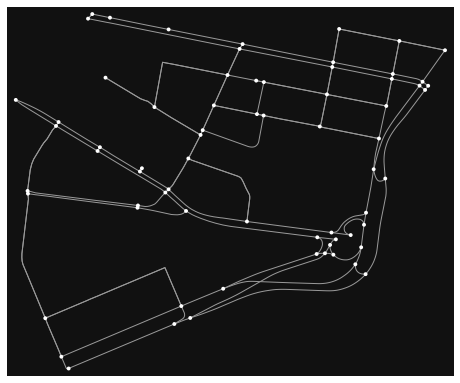

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [2]:
G = ox.graph_from_bbox(42.366313, 42.357743, -71.074014, -71.089303,  network_type='drive')

G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

Get OSM data from specific point + within specific network travel distance (in meters)

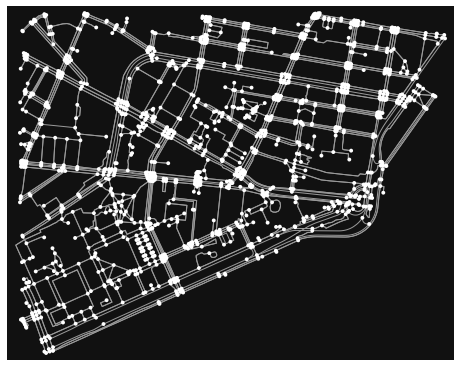

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
## argument "distance" changed to "dist" in ox version 1.0.1- 9th Feb 2020 
G = ox.graph_from_point((42.361023, -71.084675), dist=750, network_type='all')
ox.plot_graph(G)

Get OSM data from specific address + within specific network travel distance (in meters)

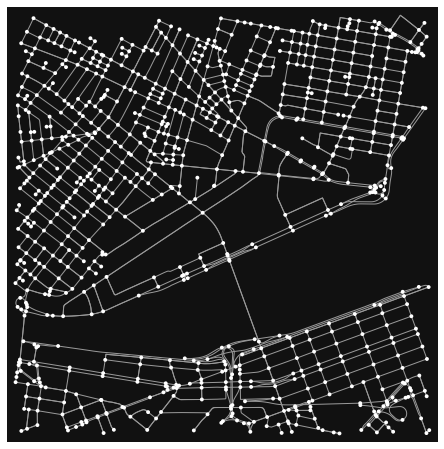

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
## argument "distance" changed to "dist" in ox version 1.0.1- 9th Feb 2020 
G = ox.graph_from_address('77 Massachusetts Avenue, Cambridge, MA 02139', dist=1500, network_type='drive')
ox.plot_graph(G)

Get OSM data for a specific place / landmark

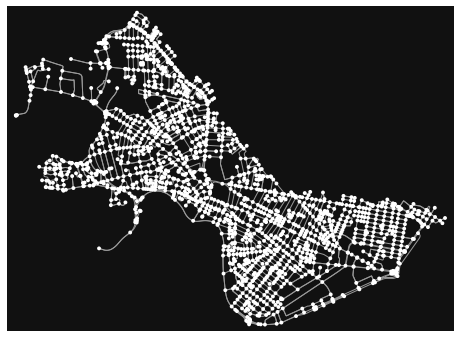

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
G = ox.graph_from_place('Cambridge, MA', network_type='drive')
ox.plot_graph(G)

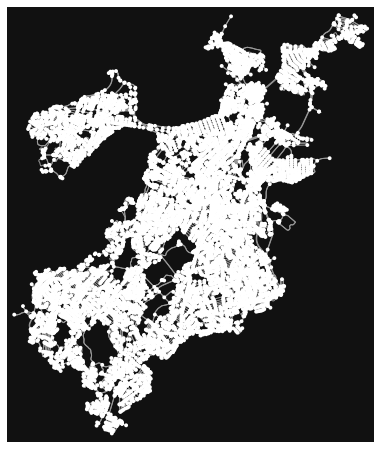

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [6]:
G = ox.graph_from_place('Boston, MA', network_type='drive')
ox.plot_graph(G)

Color graph by network properties (here: one-ways)

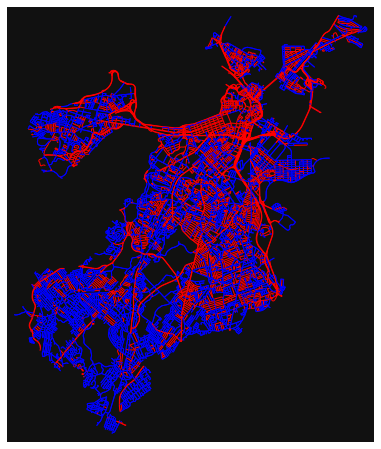

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
ox.plot_graph(G, node_size=0, edge_color=ec)

## Geocoding

### Finding Lat-Longs of Addresses

Geocode two addresses

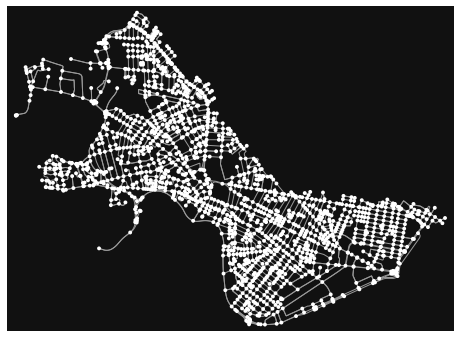

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
G = ox.graph_from_place('Cambridge, MA', network_type='drive')
ox.plot_graph(G)

In [9]:
origin = ox.geocode('77 Massachusetts Avenue, Cambridge, MA 02139')
#destination = ox.geocode('1 Amherst Street, Cambridge, MA 02142')
destination = ox.geocode('1443 Massachusetts Ave, Cambridge, MA 02138')

Plot these locations on the map

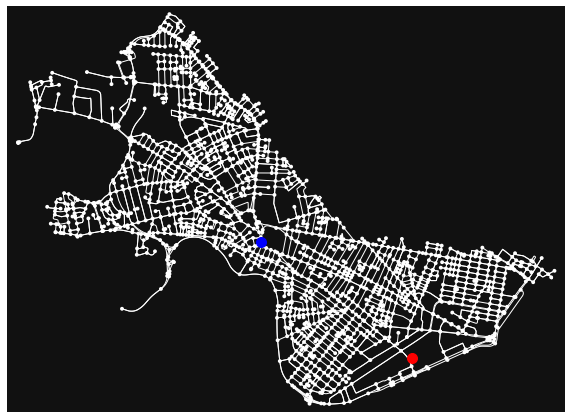

In [10]:
fig, ax = ox.plot_graph(G,  figsize=(10,10), 
                        show=False, close=False, 
                        edge_color='white')
ax.scatter(origin[1], origin[0], c='red', s=100)
ax.scatter(destination[1], destination[0], c='blue', s=100)


### Snap to Network Nodes

#### Manual (own functions)

In [11]:
def closestNode(nodes, v, invDict):
    """
    nodes: array-like of node locations (tuples)
    v: point to test
    invDict: dictionary of node location to node ID
    ------
    Note to students: replacing haversine distance with Euclidean 
        distance and scipy.distance.cdist may be slightly more efficient.
        Distortion errors from using Euclidean probably acceptable here.
    """
    
    # Function that returns the location of the node that is closest to the point tested
    closest = min(nodes, key=lambda p: haversine(
            [v[0],v[1]],
            [p[0],p[1]])
            )

    # based on that location, return the ID of the closest node
    return invDict[closest]


def projectDataOSM(point_data, graph):
    
    # create dictionary of node locations : node ID
    network_nodes = {}
    for n in graph.nodes.keys():
        network_nodes[(graph.nodes[n]['y'],graph.nodes[n]['x'])] = n
        
    # snap each point to nearest node (intersection) on road network
    
    nodes = []
    for index,row in point_data.iterrows():
        nodes.append(closestNode(network_nodes.keys(), (row.lat,row.lng), network_nodes))

    point_data['closest_node'] = nodes

In [12]:
locations = pd.DataFrame([origin, destination])
locations.columns = ['lat','lng']
locations

lat        lng
0  42.359296 -71.093083
1  42.373885 -71.118789

In [13]:
projectDataOSM(locations, G)
locations

lat        lng  closest_node
0  42.359296 -71.093083      61321312
1  42.373885 -71.118789      61329051

In [14]:
origin_node = locations['closest_node'][0]
destination_node = locations['closest_node'][1]

#### Built-in in OSMnx

Alternative (but a little less stable):

In [15]:
origin_node = ox.get_nearest_node(G,origin)
destination_node = ox.get_nearest_node(G,destination)
print(origin_node)
print(destination_node)

61321312
61329051


/Users/mwinkenb/opt/anaconda3/envs/scm293/lib/python3.6/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
/Users/mwinkenb/opt/anaconda3/envs/scm293/lib/python3.6/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


## Find and Plot Shortest Paths

Unweighted shortest path (i.e., path visiting the fewest nodes)

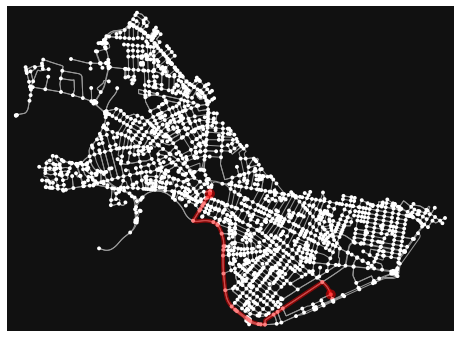

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [16]:
route = nx.shortest_path(G, origin_node, destination_node)

ox.plot_graph_route(G, route)

Distance-weighted shortest path (i.e., shortest distance)

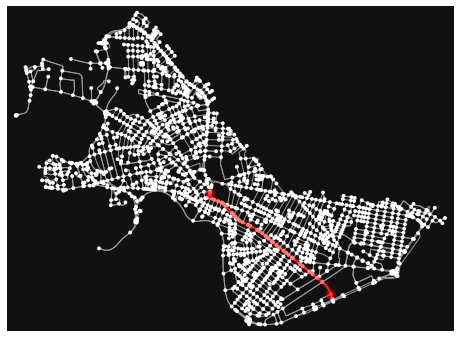

Shortest path length: 2814.3 meters


In [17]:
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
SP_distance = nx.shortest_path_length(G, origin_node, destination_node, weight='length')

ox.plot_graph_route(G, route)
print('Shortest path length: '+str(round(SP_distance,1))+' meters')

# Interactive Maps with Folium

In [18]:
my_folium_map = ox.folium.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=1, fit_bounds=True, edge_color=None, edge_width=None, edge_opacity=None)

In [19]:
ox.folium.plot_route_folium(G, route, route_map=my_folium_map, popup_attribute=None, tiles='cartodbpositron', zoom=1, fit_bounds=True, route_color=None, route_width=None, route_opacity=None, color='red')